In [1]:
import numpy as np
import matplotlib.pyplot as plt
import levenberg_marquardt as LM
from scipy import signal
from scipy.io import wavfile 
from IPython.display import Audio
import soundfile as sf

from IPython.core.display import HTML
HTML(r"""
<style>
    .jp-MarkdownCell .jp-RenderedHTMLCommon {
        font-family: "Times New Roman", Times, serif;
        font-size: 20px
    }
</style>
""")

# Levenberg-Marquardt Algorithm
commented because of the modification of orinigal LM code in the end

uncomment y_hat in the lm_func() to run the example beblow


In [27]:
# # generate test data
# p_true = np.array([[6,20,1,5]]).T
# # define initial guess of parameters (must be 2D array)
# p_init = np.array([[10,50,5,5.7]]).T
# # number of data points (x-values will range from 0 to 99)
# Npnt = 100 
# # adding noise to input data to simulate artificial measurements
# msmnt_err = 0.5 
# x = np.array(range(Npnt)).T
# y_true = LM.lm_func(x,p_true)
    
# # add random measurement errors
# rng = np.random.default_rng()
# y = y_true + msmnt_err*rng.random((Npnt))

In [28]:
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(y_true)
# plt.title('true signal')

# plt.subplot(1, 2, 2)
# plt.title('true signal + measurements errors')
# plt.plot(y)

# plt.show()

In [29]:
#p_fit,Chi_sq,sigma_p,sigma_y,corr,R_sq,cvg_hst = LM.lm(p_init,x,y)

In [30]:
#LM.make_lm_plots(x, y, cvg_hst)

# nonlinear block

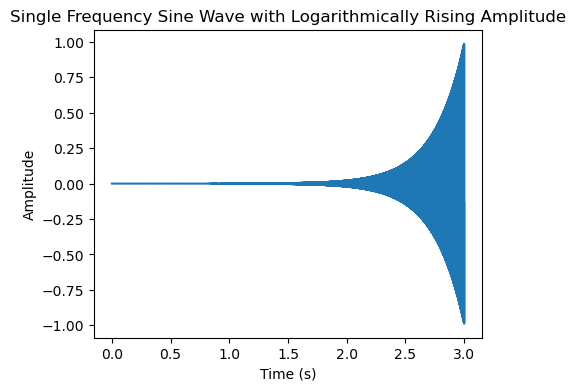

In [58]:
# Input signal
# Parameters
duration = 3.0  # Duration of the signal in seconds
fs = 44100  # Sampling rate in Hz
f0 = 1000  # Frequency of the sine wave in Hz
amplitude_start = 1e-5  # Starting amplitude
amplitude_end = 0.99  # Ending amplitude

# Time array
t = np.linspace(0, duration, int(duration * fs), endpoint=False)

# Amplitude array (logarithmically rising)
amplitude = np.exp(np.linspace(np.log(amplitude_start), np.log(amplitude_end), len(t)))

# Generate sine wave
input = amplitude * np.sin(2 * np.pi * f0 * t)

# Plot the signal
plt.figure(figsize=(5, 4))
plt.plot(t, input)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Single Frequency Sine Wave with Logarithmically Rising Amplitude')
plt.show()

In [59]:
Audio(data = input, rate = fs)

In [60]:
wavfile.write('input.wav', fs, input*0.6)

In [84]:
data, fs = sf.read('bigMuff.wav')
x = data[:,0] # stereo to mono
t = np.linspace(0, len(x)/fs, len(x))
Audio(data = x*0.1, rate = fs)  # LOUD!!

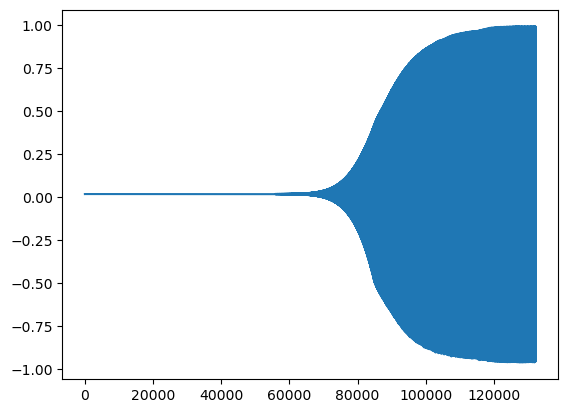

In [85]:
plt.plot(x)

In [86]:
def mapping(x, k_p, k_n, g_p, g_n):
    if x > k_p:
        m = np.tanh(k_p) - ((np.tanh(k_p)**2-1)/g_p * np.tanh(g_p * x - k_p))
    
    if x >= -k_n and x <= k_p:
        m = np.tanh(x)
    
    if x < -k_n:
        m = -np.tanh(k_n) - ((np.tanh(k_n)**2-1)/g_n * np.tanh(g_n * x - k_n))

    return m

In [87]:
sos = signal.iirfilter(4, Wn=5, fs=fs, btype="low",
                             ftype="butter", output="sos")

In [88]:
def nonLinearBlock(x, g_pre, g_bias, k_p, k_n, g_p, g_n, g_wet, g_post, sos):

    y = np.zeros_like(x)
    x_m = np.zeros_like(x)
    
    g_dry = 1 - g_wet

    x_pre = g_pre * x
    x_bias = signal.sosfilt(sos, np.abs(x))
    for n in range(len(x)):
        x_m[n] = mapping(x_pre[n] - g_bias * x_bias[n], k_p, k_n, g_p, g_n)
    
        y[n] = g_post * (g_dry * x_pre[n] + g_wet * x_m[n])

    return y

In [89]:
# define initial guess of parameters (must be 2D array)
# g_pre, g_bias, k_p, k_n, g_p, g_n, g_wet, g_post
p_init = np.array([[5, 0.46, 0.57, -0.44, 0.38, -0.55, 0.9, 0.88]]).T

# y = nonLinearBlock(input, p_init[0], p_init[1], p_init[2], p_init[3], p_init[4], p_init[5]
#                    , p_init[6], p_init[0],  sos)

y = LM.lm_func(t,p_init)
y = y / np.max(np.abs(y))


In [90]:
Audio(data = y, rate = fs)

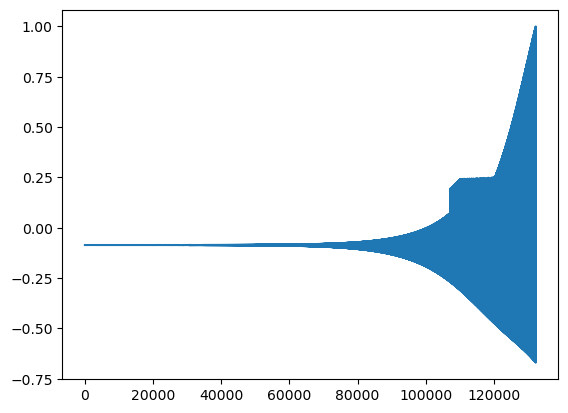

In [91]:
plt.plot(y)

In [92]:
p_fit,Chi_sq,sigma_p,sigma_y,corr,R_sq,cvg_hst = LM.lm(p_init,t,x)

Using uniform weights for error analysis
**** Convergence in Parameters ****

LM fitting results:
----------------------------- 
parameter      = p1
fitted value   = 28.9702
standard error = 0.00 %
----------------------------- 
parameter      = p2
fitted value   = 0.0691
standard error = 1.03 %
----------------------------- 
parameter      = p3
fitted value   = -0.0443
standard error = -1.60 %
----------------------------- 
parameter      = p4
fitted value   = 2.5501
standard error = 0.03 %
----------------------------- 
parameter      = p5
fitted value   = -1.1863
standard error = -0.06 %
----------------------------- 
parameter      = p6
fitted value   = 1.4774
standard error = 0.05 %
----------------------------- 
parameter      = p7
fitted value   = 0.9989
standard error = 0.07 %
----------------------------- 
parameter      = p8
fitted value   = -0.2000
standard error = -0.36 %


In [93]:
y = LM.lm_func(t, p_fit)

In [94]:
Audio(data = y, rate = fs)

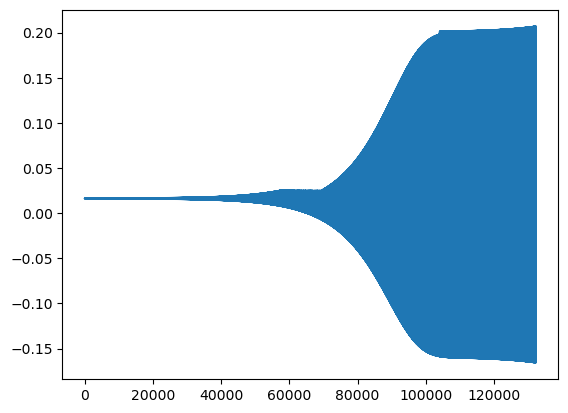

In [95]:
plt.plot(y)

In [96]:
#LM.make_lm_plots(t, y, cvg_hst)

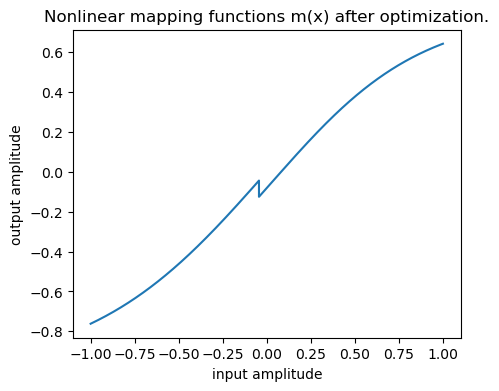

In [101]:
# Visualise the mapping function using p_fit
t = np.linspace(-1, 1, fs)
m = np.zeros_like(t)
for n in range(len(t)):
    m[n] = mapping(t[n], p_fit[2], p_fit[3], p_fit[4], p_fit[5])

plt.figure(figsize=(5, 4))
plt.plot(t, m)
plt.xlabel('input amplitude')
plt.ylabel('output amplitude')
plt.title('Nonlinear mapping functions m(x) after optimization.')

plt.show()

mapping function does not look correct

# References

- https://github.com/abnerbog/levenberg-marquardt-method/tree/main